<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/zoning_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
!pwd

/content


In [3]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#label csv
austin_df = pd.read_csv("/content/drive/My Drive/Data/data/austin.csv")
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty
0,data/austin_0.jpg,229791,PUD
1,data/austin_1.jpg,229791,PUD
2,data/austin_2.jpg,400523442,I-RR
3,data/austin_3.jpg,229791,PUD
4,data/austin_4.jpg,229791,PUD


In [10]:
residential = ['LA',
            'RR',
            'SF-1',
            'SF-2',
            'SF-3',
            'SF-4A',
            'SF-4-A,'
            'SF-4B',
            'SF-5',
            'SF-6',
            'MF-1',
            'MF-2',
            'MF-3',
            'MF-4',
            'MF-5',
            'MF-6',
            'MF-CO',
            'MH']

commercial = ['NO',
            'LO',
            'GO',
            'CR',
            'LR',
            'GR',
            'L',
            'CBD',
            'DMU',
            'W/LO',
            'CS',
            'CS-1',
            'CH']

industrial = ['IP', 'LI', 'MI', 'R&D']

special = ['DR', 'AV', 'AG', 'P', 'PUD', 'TN', 'ERC', 'UNZ']

In [11]:
#loop through list of zone codes, map specific zone codes to R, C, I, or S
austin_df.loc[:, 'zone'] = np.nan

for i in residential:
    austin_df.loc[:, 'zone'] = np.where(austin_df.loc[:, 'zoning_zty'].str.contains(i) == True, 
                                     'R', austin_df.loc[:,'zone'])
for i in industrial:
    austin_df.loc[:, 'zone'] = np.where(((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & (austin_df.loc[:, 'zone'] != 'R')), 
                                     'I', austin_df.loc[:,'zone'])
for i in commercial:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R') & (austin_df.loc[:, 'zone'] != 'I'), 
                                     'C', austin_df.loc[:,'zone'])
for i in special:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'I') & (austin_df.loc[:, 'zone'] != 'R') &\
                                     (austin_df.loc[:, 'zone'] != 'C'), 
                                     'S', austin_df.loc[:,'zone'])

In [12]:
#manually set this one
austin_df.loc[303, 'zone'] = 'R'

In [13]:
austin_df.head()

,image_name,zoning_id,zoning_zty,zone
0,data/austin_0.jpg,229791,PUD,S
1,data/austin_1.jpg,229791,PUD,S
2,data/austin_2.jpg,400523442,I-RR,R
3,data/austin_3.jpg,229791,PUD,S
4,data/austin_4.jpg,229791,PUD,S


(array([1235.,    0.,    0., 1747.,    0.,    0.,  446.,    0.,    0.,
         239.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

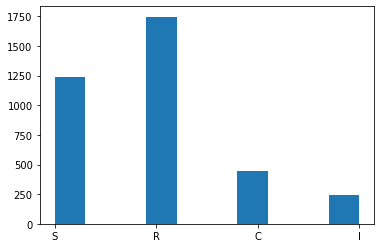

In [14]:
plt.hist(austin_df['zone'])

In [15]:
zone_class = list(austin_df['zone'])

In [16]:
img_names = austin_df['image_name']

In [21]:
img_df = []
for i in img_names:
  img_df.append(cv2.imread("/content/drive/My Drive/Data/" + str(i[:-4])+".jpg"))

In [22]:
dim = (500, 500)

In [23]:
#make images equal pixel by 500, 500 
for i, img in enumerate(img_df):
  img_df[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

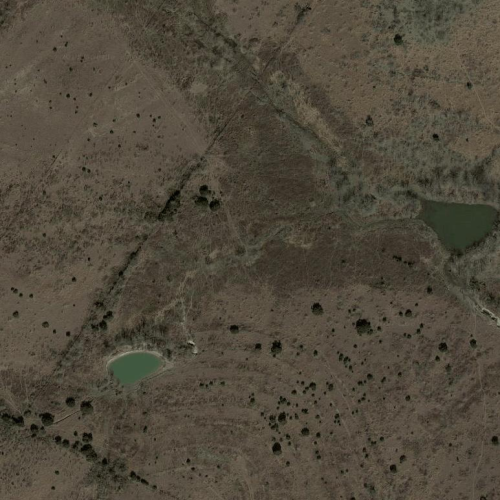

(500, 500, 3)

In [24]:
cv2_imshow(img_df[30])
img_df[0].shape

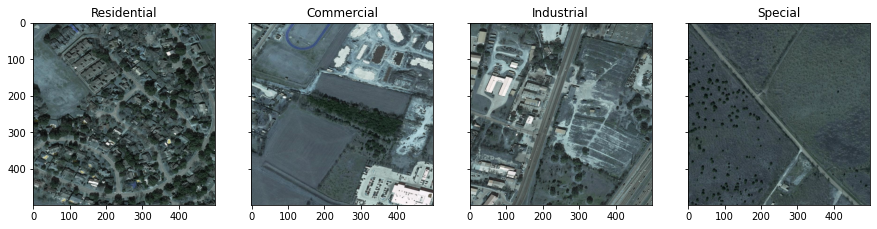

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.imshow(img_df[53], vmin=0, vmax=255, cmap=plt.cm.gray)
ax1.set_title('Residential')

ax2.imshow(img_df[138], vmin=0, vmax=255, cmap=plt.cm.gray)
ax2.set_title('Commercial')

ax3.imshow(img_df[397], vmin=0, vmax=255, cmap=plt.cm.gray)
ax3.set_title('Industrial')

ax4.imshow(img_df[72], vmin=0, vmax=255, cmap=plt.cm.gray)
ax4.set_title('Special')


plt.show()

In [53]:
img_df2 = np.array(img_df) 
zone_class = np.array(zone_class) 
#split labels and images for train&test
X_train, X_test, y_train, y_test = train_test_split(img_df2, zone_class, test_size=.2)
input_shape = (500, 500, 3)

In [54]:
model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(7, 7),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(167, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))


In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 494, 494, 32)      4736      
                                                                 
 batch_normalization_6 (Batc  (None, 494, 494, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 247, 247, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 243, 243, 32)      25632     
                                                                 
 batch_normalization_7 (Batc  (None, 243, 243, 32)     128       
 hNormalization)                                                 
                                                      

In [56]:
model.compile(optimizer= tf.keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [57]:
batch_size = 30
epochs = 50

In [58]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs)

InternalError: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusion_matrix =  pd.crosstab(index=y_test, columns=pred_labels.ravel(), rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
# Plot Confusion Matrices
plt.suptitle('Confusion Matrix', fontsize=TITLE_SIZE, fontweight='bold')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
plt.subplots_adjust(hspace=.7)  